<a href="https://colab.research.google.com/github/SuhoparovYD/Public/blob/main/Up_14_14_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание музыки народов мира.

База для распознавания аудио (народная музыка)

1. Парсинг и нормализацию данных.
2. Разделение на обучающую и проверочную выборки
3. Классификация 
4. Ввыводы

In [ ]:
# Загрузка библиотек
from google.colab import files
import os   # Работа с ОС
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данны
import librosa    # Параметризация аудио
import librosa.display #Для отображения аудио сигналов

from keras.optimizers import Adam # Оптимизатор для задания шага обучения
from keras.models import Model # модель keras
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D # Базовые слови
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import utils # Для to_categorical
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip -q '/content/drive/MyDrive/folk.zip' -d /content/drive/MyDrive/folkmusic  # Народные песни стран 

1. Парсинг и нормализация данных.

In [ ]:
# Формируем обучающую выборку

x_mfcc = []     # Списки для параметров  х_train
x_stft = [] 
x_rmse = []
x_spec = []
x_roll = []
x_zcrs = []
yt = []         # Список для y_train

categories = []   # Список для стран (народной музыки)
countries = sorted(os.listdir('/content/drive/MyDrive/folkmusic'))   # На диске музыка расположениа по папкам с названием  стран
for i in range(len(countries)):               # Проходим по всем странам
  cn = countries[i]                           # текущяя страна
  categories.append(cn)                       # заполняум саписок категорий
  for filename in os.listdir(f'/content/drive/MyDrive/folkmusic/{cn}'):  # по файлам папки
    songname = f'/content/drive/MyDrive/folkmusic/{cn}/{filename}'
    y, sr = librosa.load(songname, mono=True)                        # загружаем очередную народную песню
    for sec in range(len(y)//sr-1):                                  # Превращаем сигнал в параметризованные данные
      ys = y[sec*sr:(sec+1)*sr]                                      # Текущий указатель в файле песни
      x_mfcc.append(librosa.feature.mfcc(ys, sr,n_mfcc=40))          # Мел спектральные коэффициенты 
      x_stft.append(librosa.feature.chroma_stft(ys, sr))             # Частота цветности
      x_rmse.append(librosa.feature.spectral_centroid(ys, sr))       # Спектральный центроид
      x_spec.append(librosa.feature.rms(ys))                         # Среднеквадратичная амплитуда
      x_roll.append(librosa.feature.spectral_rolloff(ys, sr))        # Cпектральный спад частоты
      x_zcrs.append(librosa.feature.zero_crossing_rate(ys))          # Частота пересечения нуля
      yt.append(i) 

  print("Страна ", cn, " готова ", sep="")     # информация о готовности 

x_mfcc = np.array(x_mfcc)     # Превращаем выборку в numpy массивы
x_stft = np.array(x_stft)
x_spec = np.array(x_spec) 
x_rmse = np.array(x_rmse)
x_roll = np.array(x_roll)
x_zcrs = np.array(x_zcrs)
yt = np.array(yt)

print(x_mfcc.shape, x_stft.shape, x_spec.shape, x_zcrs.shape, yt.shape)   # смотрим результ

Страна Англия готова 
Страна Армения готова 
Страна Германия готова 
Страна Индия готова 
Страна Ирландия готова 
Страна Испания готова 
Страна Италия готова 
Страна Китай готова 
Страна Куба готова 
Страна Мексика готова 
Страна Россия готова 
Страна Финляндия готова 
Страна Франция готова 
Страна Шотландия готова 
(9863, 40, 44) (9863, 12, 44) (9863, 1, 44) (9863, 1, 44) (9863,)


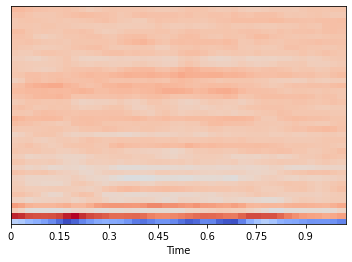

In [ ]:
# Пример Мел спектрограммы
index = np.random.randint(0,x_mfcc.shape[0])
librosa.display.specshow(x_mfcc[index], sr=sr, x_axis='time') # Отобразим Мел спектрограммы 
plt.show() # выведим график

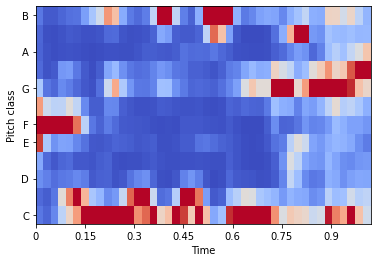

In [ ]:
# Пример спектрограммы
librosa.display.specshow(x_stft[index], x_axis='time', y_axis='chroma',  cmap='coolwarm') # Отобразим спектрограммы
plt.show() # выведим график

Нормализация

In [ ]:
def mscaler(x):     # Масштабирование данных
  min = x.min()
  max = x.max()
  return (x - min) / (max - min)

x_mfcc = mscaler(x_mfcc)
x_stft = mscaler(x_stft)
x_spec = mscaler(x_spec) 
x_rmse = mscaler(x_rmse)
x_roll = mscaler(x_roll)
x_zcrs = mscaler(x_zcrs)

yt =  utils.to_categorical(yt, len(categories))   # y -> to_categorical

print(yt[index],'\n',x_mfcc[index])  # результат

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] 
 [[0.7388399  0.73036486 0.71116334 ... 0.6796501  0.6761887  0.66621035]
 [0.9163063  0.91146094 0.89854753 ... 0.8354206  0.8392033  0.84502846]
 [0.80596256 0.7965828  0.77968293 ... 0.7821799  0.7863889  0.79562795]
 ...
 [0.8097506  0.81211054 0.81337595 ... 0.8179481  0.8183197  0.8195973 ]
 [0.81597465 0.8167536  0.8142141  ... 0.8105018  0.80821854 0.807787  ]
 [0.82407534 0.8234507  0.8200029  ... 0.8118636  0.8123817  0.8130031 ]]


In [ ]:
x_spec = x_spec.reshape(x_spec.shape[0],44,1) # Решейп массивов
x_rmse = x_rmse.reshape(x_rmse.shape[0],44,1) 
x_roll = x_roll.reshape(x_roll.shape[0],44,1) 
x_zcrs = x_zcrs.reshape(x_zcrs.shape[0],44,1) 


# Создаём модель

In [ ]:
in_mfcc = Input((40, 44, 1))        # Входной слой для mfcc
in_stft = Input((12, 44, 1))        # Входной слой для chroma_stft
in_spec = Input((44, 1))            # Входной слой для spec_cent 
in_rmse = Input((44, 1))            # Входной слой для rmse
in_roll = Input((44, 1))            # Входной слой для 
in_zcrs = Input((44, 1))            # Входной слой для 

# Анализ mfcc
x1 = Conv2D(32, (3,3), padding="same", activation="elu")(in_mfcc)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = MaxPooling2D(2)(x1)
x1_m1 = Flatten()(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)
x1 = MaxPooling2D(2)(x1)
x1_m2 = Flatten()(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = BatchNormalization()(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Flatten()(x1)

# stft
x2 = Conv2D(32, (3,3), padding="same", activation="elu")(in_stft)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
x2_g = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(32, (3,3), padding="same", activation="elu")(x2)
x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Flatten()(x2)

# spec_cent 
x3 = Conv1D(16, 3, padding="same", activation="elu")(in_spec)
x3 = BatchNormalization()(x3)
x3 = Dropout(0.25)(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(16, 3, padding="same", activation="elu")(x3)
x3 = BatchNormalization()(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Flatten()(x3)

# rmse
x4 = Conv1D(16, 3, padding="same", activation="elu")(in_rmse)
x4 = BatchNormalization()(x4)
x4 = Dropout(0.25)(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(8, 3, padding="same", activation="elu")(x4)
x4 = BatchNormalization()(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Flatten()(x4)

# roll
x5 = Conv1D(16, 3, padding="same", activation="elu")(in_roll)
x5 = BatchNormalization()(x5)
x5 = Dropout(0.25)(x5)
x5 = MaxPooling1D(2)(x5)
x5 = Conv1D(8, 3, padding="same", activation="elu")(x5)
x5 = BatchNormalization()(x5)
x5 = MaxPooling1D(2)(x5)
x5 = Flatten()(x5)

# zcrs
x6 = Conv1D(16, 3, padding="same", activation="elu")(in_zcrs)
x6 = BatchNormalization()(x6)
x6 = Dropout(0.25)(x6)
x6 = MaxPooling1D(2)(x6)
x6 = Conv1D(8, 3, padding="same", activation="elu")(x6)
x6 = BatchNormalization()(x6)
x6 = MaxPooling1D(2)(x6)
x6 = Flatten()(x6)


# Объедияем блоки
x = concatenate([x1, x1_m1, x1_m2, x2, x2_g, x3, x4,  x5, x6])

# Полносвязные слои на выходе
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(len(categories), activation='softmax')(x)

model = Model([in_mfcc, in_stft, in_spec, in_rmse, in_roll, in_zcrs], x)

model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

2. Разделение данных на обучающую и проверочную выборки

In [ ]:
# Маска для разделения на тренировочную и валидационную выборки
val_mask = np.random.sample(x_rmse.shape[0])  # Mаскa для обучающей и проверочной выборки
tm= val_mask < 0.8    # маскa для обучающей  выборки
vm = val_mask >= 0.8  # маскa для проверочной выборки

3. Классификация

Epoch 1/50
124/124 [==============================] - 100s 599ms/step - loss: 6.7979 - accuracy: 0.1263 - val_loss: 2.5872 - val_accuracy: 0.0810
Epoch 2/50
124/124 [==============================] - 72s 582ms/step - loss: 2.1167 - accuracy: 0.2714 - val_loss: 2.7355 - val_accuracy: 0.0810
Epoch 3/50
124/124 [==============================] - 72s 583ms/step - loss: 1.7729 - accuracy: 0.3882 - val_loss: 2.6407 - val_accuracy: 0.0923
Epoch 4/50
124/124 [==============================] - 72s 583ms/step - loss: 1.4749 - accuracy: 0.4972 - val_loss: 2.3359 - val_accuracy: 0.1779
Epoch 5/50
124/124 [==============================] - 72s 581ms/step - loss: 1.2876 - accuracy: 0.5648 - val_loss: 2.0051 - val_accuracy: 0.2727
Epoch 6/50
124/124 [==============================] - 72s 578ms/step - loss: 1.1280 - accuracy: 0.6122 - val_loss: 5.7154 - val_accuracy: 0.1179
Epoch 7/50
124/124 [==============================] - 72s 580ms/step - loss: 1.0244 - accuracy: 0.6434 - val_loss: 6.9049 - val_a

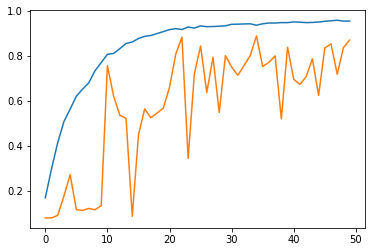

In [ ]:

# Добавляем коллбэк  для уменьшения шага обучения
def scheduler(epoch, lr):
  if epoch % 10 ==0:
     lr /=2
  return lr

callback = LearningRateScheduler(scheduler)
# Обучаем модель
history = model.fit([x_mfcc[tm], x_stft[tm], x_spec[tm], x_rmse[tm], x_roll[tm], x_zcrs[tm]],  yt[tm],
                    epochs=50, batch_size=64,
                    validation_data=([x_mfcc[vm], x_stft[vm], x_spec[vm], x_rmse[vm], x_roll[vm], x_zcrs[vm]],
                                     yt[vm] ), callbacks=[callback])

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

# Рассмотрим как распознались народные песни разных стран

In [ ]:
for m in range(len(categories)) :
  m2 = np.argmax(yt, axis=1) == m   # Маска на страну
  v = vm & m2                       # Объединяем маску страны и тестовой выборки
  print(m, categories[m])           # Печатаем результат на тестовой выборке
  model.evaluate([x_mfcc[v], x_stft[v], x_spec[v], x_rmse[v], x_roll[v], x_zcrs[v]],
                                     yt[v], batch_size=yt[v].shape[0])

0 Англия
1/1 [==============================] - 2s 2s/step - loss: 2.1820 - accuracy: 0.6346
1 Армения
1/1 [==============================] - 2s 2s/step - loss: 0.3080 - accuracy: 0.9528
2 Германия
1/1 [==============================] - 0s 162ms/step - loss: 0.3697 - accuracy: 0.9242
3 Индия
1/1 [==============================] - 0s 443ms/step - loss: 0.1015 - accuracy: 0.9696
4 Ирландия
1/1 [==============================] - 0s 296ms/step - loss: 0.5732 - accuracy: 0.8824
5 Испания
1/1 [==============================] - 0s 329ms/step - loss: 0.0543 - accuracy: 0.9804
6 Италия
1/1 [==============================] - 0s 382ms/step - loss: 1.1276 - accuracy: 0.7079
7 Китай
1/1 [==============================] - 0s 135ms/step - loss: 2.0076 - accuracy: 0.6481
8 Куба
1/1 [==============================] - 0s 356ms/step - loss: 1.5651 - accuracy: 0.6557
9 Мексика
1/1 [==============================] - 0s 259ms/step - loss: 0.9687 - accuracy: 0.7008
10 Россия
1/1 [===========================

# Схема модели

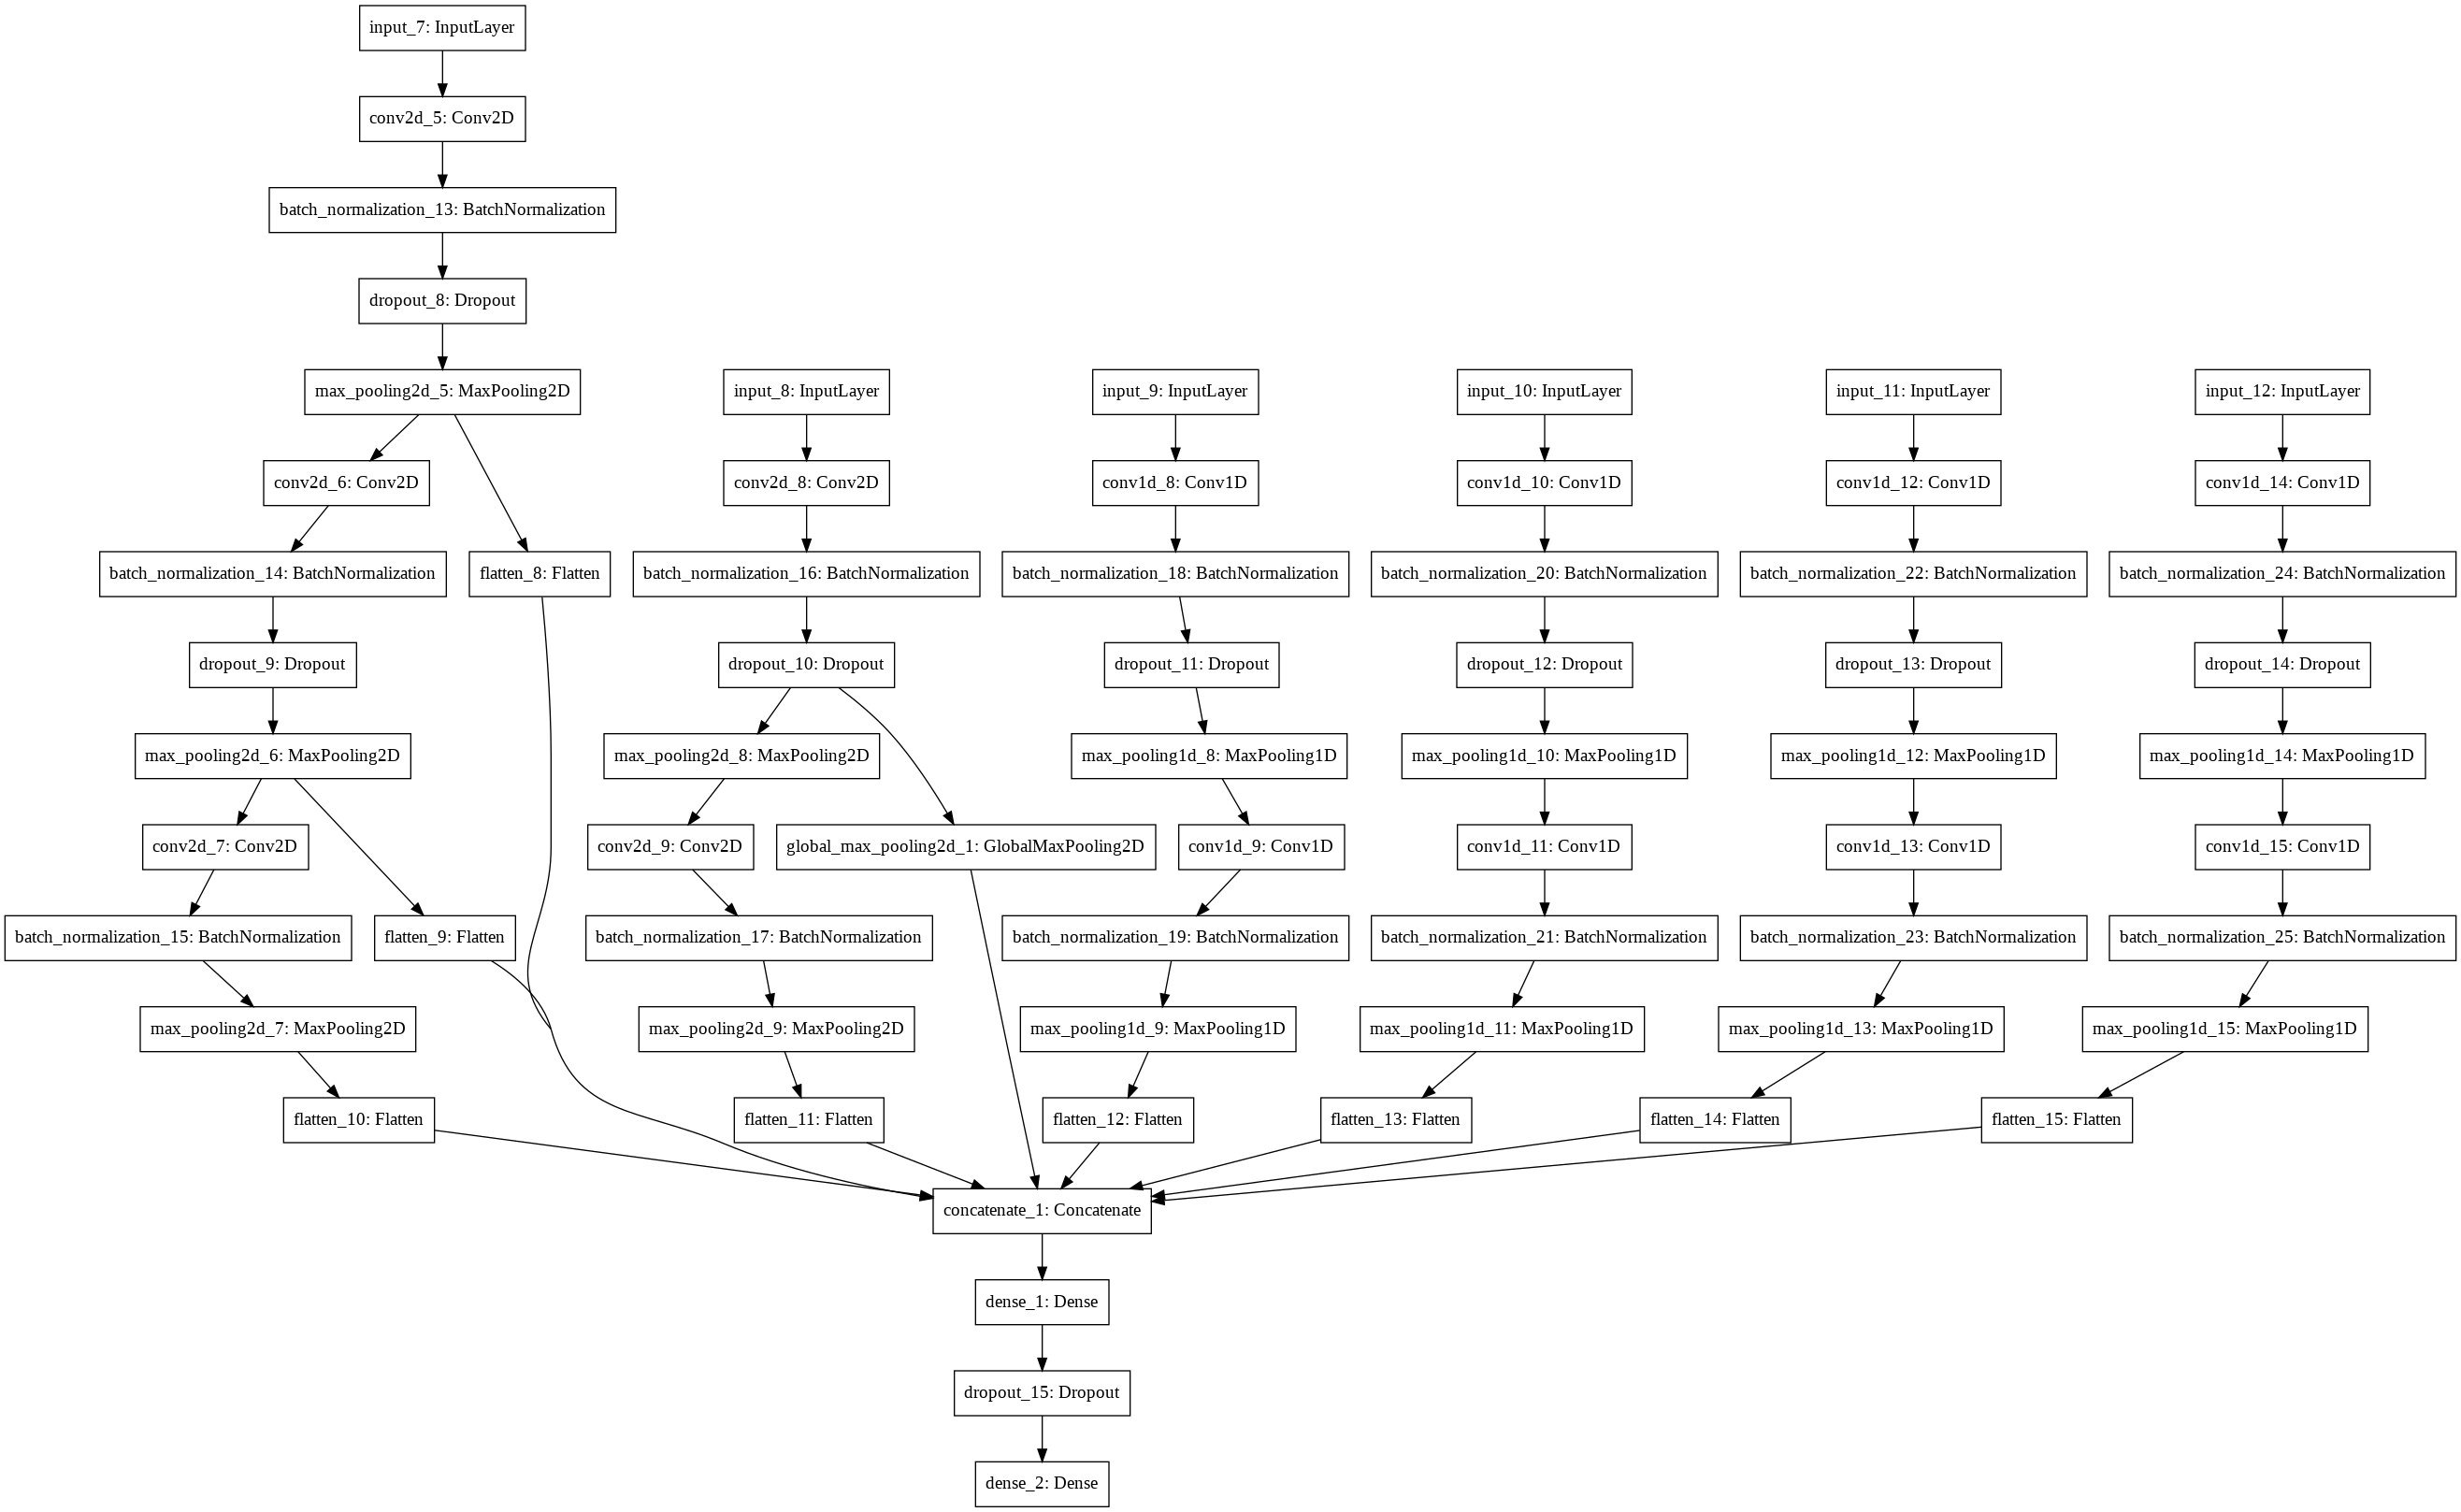

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Выводы:

1.   Модель не претендует на распознавание любой (народной) музыки, а скорее демонстрирует возможность распознавания данного набора музыки.
2.   Модель страдает "переобучением", по причине малого объема данных.
3.   Сложность и "мощность" модели выбраны из условий оптимальной работы на имеющемся наборе данных. 
4.   На более полных наборах данных потребуется более мощная модель, но основные закономерности останутся.
5.  В целом удалось продемонстрировать распознавания жанров музыки на примере музыки народов мира.